In [9]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path:
    sys.path.append('..')
    
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import os

from lib.mobilitysim import MobilitySimulator
from lib.town_data_specify_essential_prop import generate_population, generate_sites, compute_distances
from lib.town_maps import MapIllustrator

downsample_population = 100 # Downsample population numbers by a factor of 20
downsample_sites = 20 # Downsample sites by a factor of 10

# Set the population generation mode.
# 3 options available: custom | random | heuristic
population_by = 'custom'

population_path='lib/data/population/' # Directory containing FB population density files
sites_path='lib/data/queries/' # Directory containing OSM site files
bbox = (48.4900, 48.5485, 9.0224, 9.1061) # Coordinate bounding box

# Population per age group in Landkreis Tübingen
population_per_age_group = np.array([
    13416, # 0-4
    18324, # 5-14
    67389, # 15-34
    75011, # 35-59
    41441, # 60-79
    11750])# 80+

# Downsample population to Town of Tübingen (to be consistent with case data)
a = 90546 / (downsample_population * 227331)
population_per_age_group = np.round(
    population_per_age_group * a).astype('int').tolist()

essential_to_total_ratio = 0.1
num_essential_workers = np.floor(sum(population_per_age_group)*essential_to_total_ratio).astype('int').tolist()
print(num_essential_workers,sum(population_per_age_group))

essential_type = 4 # supermarket worker

essential_distribution = np.array([
    0,      # 0-4
    0,      # 5-14
    0.5,    # 15-34
    0.45,   # 34-59
    0.05,   # 60-79
    0])     # 80+

num_essential_per_age_group = np.floor(num_essential_workers * essential_distribution).astype('int').tolist()
essential_prop_per_age_group = np.divide((num_essential_per_age_group),(population_per_age_group))

# This block sends queries to OpenStreetMap
# Make sure you have a working internet connection
# If an error occurs during execution, try executing again
site_files=[]
for root,dirs,files in os.walk(sites_path):
    for f in files:
        if f.endswith(".txt") and f != 'buildings.txt':
            site_files.append(sites_path+f)

site_loc, site_type, site_dict, density_site_loc = generate_sites(bbox=bbox, query_files=site_files,
                                site_based_density_file='lib/data/queries/buildings.txt')

if downsample_sites > 1:
    np.random.seed(42)
    # downsample sites like populatoin
    idx = np.random.choice(len(site_loc), size=int(len(site_loc) / downsample_sites), 
                           replace=False, p=np.ones(len(site_loc)) / len(site_loc))

    new_site_loc, new_site_type = [], []
    site_loc, site_type = np.array(site_loc)[idx].tolist(), np.array(site_type)[idx].tolist()
    
density_files=[]
for root,dirs,files in os.walk(population_path):
    for f in files:
        if f.endswith(".csv"):
            density_files.append(population_path+f)

if population_by == 'custom':
    # generate population across tiles based on density input
    home_loc, people_age, home_tile, tile_loc, essential_workers, num_essential_workers, essential_work_site = generate_population(density_files=density_files, bbox=bbox,
        population_per_age_group=population_per_age_group, tile_level=16, seed=42,
        essential_prop_per_age_group=essential_prop_per_age_group,
        site_type = site_type, essential_type = essential_type)
    
elif population_by == 'random':
    # generate population across tiles uniformly at random
    home_loc, people_age, home_tile, tile_loc, essential_workers, num_essential_workers = generate_population(
        bbox=bbox, population_per_age_group=population_per_age_group,
        tile_level=16, seed=42,
        essential_prop_per_age_group=essential_prop_per_age_group)

elif population_by == 'heuristic':
    # generate population across tiles proportional to buildings per tile
    home_loc, people_age, home_tile, tile_loc, essential_workers, num_essential_workers = generate_population(bbox=bbox, density_site_loc=density_site_loc,
                            population_per_age_group=population_per_age_group, tile_level=16, seed=42,
        essential_prop_per_age_group=essential_prop_per_age_group)
    
essential_to_total_pop_ratio = num_essential_workers/sum(population_per_age_group)

tile_site_dist = compute_distances(site_loc, tile_loc)

# 2h at office-education, 1.5h at restaurants/bars, 0.5 at supermarket, 0.2 at bus stop.
dur_mean_per_type = [2, 1.5, 0.2, 2, 0.5]
essential_dur_mean_per_type = [0.0 , 0.0 , 0.0 , 0.0, 8.0]

# 1 office, 1 school, 10 social, 2 supermarkets, 5 bus stops
variety_per_type = [1, 10, 5, 1, 2]

# e.g. line 0 corresponds to age 0-4 : 
# no office, a lot of education (kindergarden), some social, no supermarket, no public transport 
# school, social, bus, office, supermarket
mob_rate_per_age_per_type = [
    [5, 1, 0, 0, 0], # 0-4
    [5, 2, 1, 0, 0], # 5-14
    [2, 2, 1, 1, 1], # 15-34
    [0, 2, 1, 5, 1], # 35-59
    [0, 3, 2, 0, 1], # 60-79
    [0, 2, 1, 0, 1]] # 80+
    
# convert to average visits per hour per week, to be compatible with simulator
mob_rate_per_age_per_type = np.divide(np.array(mob_rate_per_age_per_type), (24.0 * 7))

essential_mob_rate_per_type = [0 , 0 , 0 , 0, 7]
essential_mob_rate_per_type = np.divide(np.array(essential_mob_rate_per_type), (24.0 * 7))

# time horizon
max_time = 17 * 24.0 # data availability
delta  = 4.6438 # as set by distributions

kwargs = dict(home_loc=home_loc, people_age=people_age, site_loc=site_loc,
    site_type=site_type, mob_rate_per_age_per_type=mob_rate_per_age_per_type,
    dur_mean_per_type=dur_mean_per_type, variety_per_type=variety_per_type, delta=delta,
    home_tile=home_tile, tile_site_dist=tile_site_dist,
    essential_workers=essential_workers,
    essential_mob_rate_per_type=essential_mob_rate_per_type,
    essential_dur_mean_per_type = essential_dur_mean_per_type,
    essential_work_site = essential_work_site,
    essential_type=essential_type) # emma

with open(f'essential-workplace_settings_{downsample_population}_{downsample_sites}.pk', 'wb') as fp:
    pickle.dump(kwargs, fp)





from lib.inference import *
from lib.town_maps import MapIllustrator
from lib.town_data_specify_essential_prop import generate_population, generate_sites, compute_distances
from lib.measures import (
    MeasureList,
    BetaMultiplierMeasure,
    BetaMultiplierMeasureByType,
    SocialDistancingForAllMeasure,
    SocialDistancingForKGroups,
    SocialDistancingByAgeMeasure,
    SocialDistancingForPositiveMeasure,
    ComplianceForAllMeasure,
    ComplianceForEssentialWorkers,
    Interval)
from lib.data import collect_data_from_df
from lib.plot import Plotter
from lib.distributions import CovidDistributions
from lib.parallel import *
from bayes_opt import BayesianOptimization
from lib.dynamics import DiseaseModel
from lib.mobilitysim import MobilitySimulator
import multiprocessing
import re
import matplotlib
import warnings
import pickle
import seaborn
import math
import scipy as sp
import copy
import networkx as nx
import numpy as np
import pandas as pd
import sys

if '..' not in sys.path:
    sys.path.append('..')

if __name__ == '__main__':

    mob_settings = 'essential-workplace_settings_'+str(downsample_population)+'_'+str(downsample_sites)+'.pk'
    random_repeats = 4

    # cpus_used = multiprocessing.cpu_count()
    cpus_used = 23

    c = 0  # seed
    FIGSIZE = (8, 4)

    # #### Import town settings

    tuned_p_stay_home = 0.2
    tuned_site_multipliers = [0.0, 0.0, 0.5, 0.5, 0.5]

    # See town-generator.ipynb for an example on how to create own settings
    with open(mob_settings, 'rb') as fp:
        obj = pickle.load(fp)
    mob = MobilitySimulator(**obj)
    np.random.seed(c)
    runstr = f'run{c}_'

    # General note for plotting: `errorevery` has to be set proportionally to `acc`, and best to keep `acc` as it is
    days_until_lockdown = 13  # March 10 - March 23
    days_after_lockdown = 20  # March 24 - April 12
    days_present = days_until_lockdown + days_after_lockdown + \
        2  # simulate 2 more days due to test lag
    days_future = 12 * 7  # projecting 12 weeks into the future

    case_downsample = 10
    new_cases_ = collect_data_from_df('LK Tübingen', 'new', until=days_present)
    resistant_cases_ = collect_data_from_df(
        'LK Tübingen', 'recovered', until=days_present)
    fatality_cases_ = collect_data_from_df(
        'LK Tübingen', 'fatality', until=days_present)


    # fatality rate per age group
    num_age_groups = fatality_cases_.shape[1]
    fatality_rates_by_age = (
        fatality_cases_[-1, :] / (new_cases_[-1, :] + fatality_cases_[-1, :] + resistant_cases_[-1, :]))

    print('Empirical fatality rates per age group:  ',
          fatality_rates_by_age.tolist())

    # Scale down cases based on number of people in simulation

    new_cases, resistant_cases, fatality_cases = (
        1/case_downsample * new_cases_,
        1/case_downsample * resistant_cases_,
        1/case_downsample * fatality_cases_)
    new_cases, resistant_cases, fatality_cases = np.ceil(
        new_cases), np.ceil(resistant_cases), np.ceil(fatality_cases)

    # Define initial seed count (based on infection counts on March 10)

    initial_seeds = {
        'expo': 1,
        'ipre': 1,
        'isym': 3,
        'iasy': 3,
    }
    present_seeds = {
        'expo': 3,
        'ipre': 1,
        'iasy': 0,
        'isym_notposi': 8,
        'isym_posi': 4,
        'resi_notposi': 78,
        'resi_posi': 110,
    }
    max_time_present = 24.0 * (days_present)
    max_time_future = 24.0 * (days_future)

    # #### Define standard testing parameters, same used for inference

    def standard_testing(max_time):
        standard_testing_params = {
            'testing_t_window': [0.0, max_time],  # in hours
            'testing_frequency': 24.0,     # in hours
            # in hours (actual and self-report delay)
            'test_reporting_lag': 48.0,
            'tests_per_batch': 10,       # assume 300 tests/day in LK Tübingen
            'test_smart_delta': 24.0 * 3,  # in hours
            'test_smart_duration': 24.0 * 7,  # in hours
            'test_smart_action': 'isolate',
            'test_smart_num_contacts': 10,
            'test_targets': 'isym',
            'test_queue_policy': 'fifo',
            'smart_tracing': None,
        }
        return standard_testing_params
    # #### Define distributions as estimated by literature
    #


    # instantiate correct distributions
    distributions = CovidDistributions(
        fatality_rates_by_age=fatality_rates_by_age)

    # #### Set epidemic parameters as inferred using Bayesian optimization

    # inferred parameters (see paper)
    inferred_params = {
        'betas': [1.1383] * 5,  # site infectivity by type
        'alpha': 0.3224,
        'mu': 0.2072
    }

    # Define function to run general type of experiment, fixing the above settings.

    def run(tparam, measure_list, t, local_seeds):

        # add standard measure of positives staying isolated
        measure_list += [
            SocialDistancingForPositiveMeasure(
                t_window=Interval(0.0, t), p_stay_home=1.0)
        ]
        measure_list = MeasureList(measure_list)

        # run simulations
        summary = launch_parallel_simulations(
            mob_settings,
            distributions,
            random_repeats, cpus_used,
            inferred_params, local_seeds, tparam, measure_list,
            max_time=t,
            num_people=mob.num_people,
            num_sites=mob.num_sites,
            site_loc=mob.site_loc,
            home_loc=mob.home_loc, verbose=False)
        return summary


    def save_summary(summary, filename):
        with open('summaries/' + filename, 'wb') as fp:
            pickle.dump(summary, fp)

    def load_summary(filename):
        with open('summaries/' + filename, 'rb') as fp:
            summary = pickle.load(fp)
        return summary


    """
    ========================= END OF HEADER =========================

    """
    
    num_essen = 0
    num_non_essen = 0
    work_site = []
    for i in range(mob.num_people):
        if mob.essential_workers[i]:
            num_essen += 1
            work_site_temp = mob.essential_work_site[i]
            if work_site_temp not in work_site:
                if work_site_temp < 100:
                    work_site.append(work_site_temp)
#         print('essential worker no:',i,' working at site:',mob.essential_work_site[i])
        else:
            num_non_essen += 1

    num_workers_at_work_site = [0]*len(work_site)
    for i in range(mob.num_people):
        for j in range(len(work_site)):
            if mob.essential_work_site[i] == work_site[j]:
                num_workers_at_work_site[j] += 1
    

    print('total population:',mob.num_people,', essential:',num_essen,', non_essential:',num_non_essen,', propotion:',num_essen/mob.num_people)
    print('essential proortion per age group:',essential_prop_per_age_group)

    print('Population (by Age): ', population_per_age_group)
    print('Sites (by type):     ',  [(np.array(site_type) == i).sum() for i in range(5)])
    print('work_site:',work_site)
    print('number of workers at work site:',num_workers_at_work_site)

    print('Total:', sum(population_per_age_group), len(site_type))
    

    # ## Only simulate the future from here onwards
    #
    #

    # baseline (no measure for the future starting April 12)
    # future_baseline = run(standard_testing(max_time_future),
    #                       [], max_time_future, present_seeds)
    # save_summary(future_baseline, 'future_baseline_3.pk')

    # ### 4.3.5. Effects  of compliance on the efficacy of isolation for smart  tracing strategies

    testing_params_SD_6 = standard_testing(max_time_future)
    # time window considered for inspecting contacts
    testing_params_SD_6['test_smart_delta'] = 24.0 * 3
    testing_params_SD_6['test_smart_action'] = 'isolate'
    testing_params_SD_6['test_targets'] = 'isym'
    testing_params_SD_6['test_smart_num_contacts'] = 25
    isolation_days_SD_6 = 7  # how many days selected people have to stay in isolation
    duration_weeks_SD_6 = 12  # strategies tested for 12 weeks starting today

    summaries_SD_6 = dict()

    
    p_compliance_temp = [1.0]    
    p_compliance = [i * essential_to_total_pop_ratio for i in p_compliance_temp]
    p_compliance_essential = p_compliance_temp

    for policy in ['basic']:
        summaries_ = []
        testing_params_SD_6['smart_tracing'] = policy

        for p in p_compliance:

            m = [SocialDistancingForSmartTracing(
                t_window=Interval(*testing_params_SD_6['testing_t_window']),
                p_stay_home=1.0,
                test_smart_duration=24.0 * isolation_days_SD_6),
                ComplianceForAllMeasure(
                t_window=Interval(*testing_params_SD_6['testing_t_window']),
                p_compliance=p)
            ]
            res = run(testing_params_SD_6, m, max_time_future, present_seeds)
            summaries_.append(res)

            print('all', p, ' done.')

        
        for p_essential in p_compliance_essential:

            m = [SocialDistancingForSmartTracing(
                t_window=Interval(*testing_params_SD_6['testing_t_window']),
                p_stay_home=1.0,
                test_smart_duration=24.0 * isolation_days_SD_6),
                ComplianceForEssentialWorkers(
                t_window=Interval(*testing_params_SD_6['testing_t_window']),
                p_compliance=p_essential)
            ]
            res = run(testing_params_SD_6, m, max_time_future, present_seeds)
            summaries_.append(res)

            print('essential', p_essential, ' done.')

        
summaries_SD_6[policy] = summaries_
# save_summary(summaries_SD_6,'german_comp'+str(p_compliance_essential)+'_repeats'+str(random_repeats)+'_'+mob_settings)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
90 905
Data last updated at:  13.04.2020, 00:00 Uhr
Data last updated at:  13.04.2020, 00:00 Uhr
Data last updated at:  13.04.2020, 00:00 Uhr
Empirical fatality rates per age group:   [0.0, 0.0, 0.0, 0.001430615164520744, 0.00964630225080386, 0.11728395061728394]
total population: 909 , essential: 82 , non_essential: 827 , propotion: 0.09020902090209021
essential proortion per age group: [0.         0.         0.16791045 0.13377926 0.02424242 0.        ]
Population (by Age):  [53, 73, 268, 299, 165, 47]
Sites (by type):      [22, 8, 9, 7, 2]
work_site: [10, 33]
number of workers at work site: [38, 44]
Total: 905 48
all 0.09060773480662983  done.
essential 1.0  done.


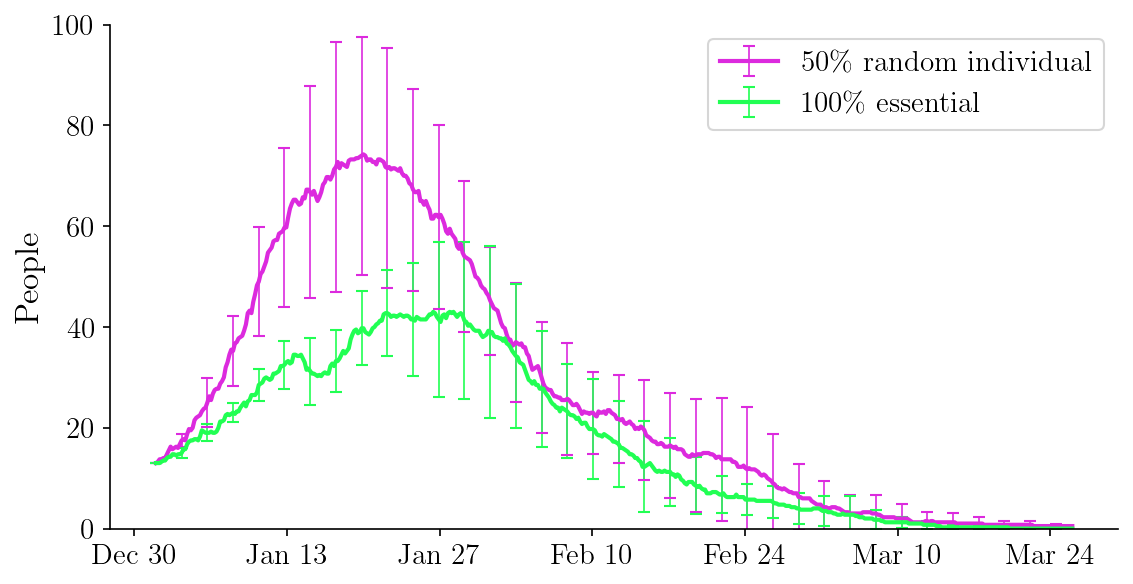

In [3]:
# downsized 100 by pop, 20 by town, 4 random repeats
# 47.19% essential to total prop, essential: 429, non-essential: 480, total: 909, sites:47
# compare supermarket & restuarant workers compliant vs. random complaint, number of compliant ~=
# compare 100% compliance for supermarket & restuarant, 50% for random individual
# mob rate regular: same as German town
# mob rate bus: 5 days per week,5 hours per day, essential_mob_rate_per_type = [0.0 , 0.0 , 5.0 , 5.0, 0.0]
# mob rate office: 5 days per week,5 hours per day,essential_dur_mean_per_type = [0.0 , 0.0 , 5.0 , 5.0, 0.0]
# mob rate zero elsewhere
# run 1

plotter = Plotter()
# titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance_essential])
titles_SD_6_ = ['50\% random individual','100\% essential']
for j, policy in enumerate(['basic']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' tracing isolation'),
        filename=runstr + f'SD_6{j}', 
        figsize=FIGSIZE, acc=500, 
        ymax=100, errorevery=14)

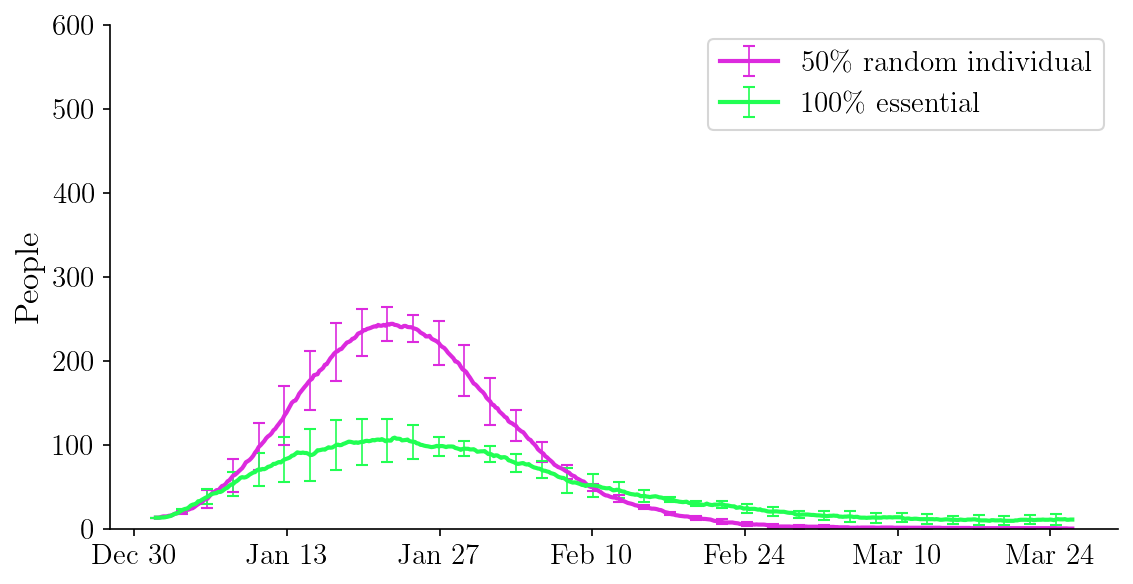

In [14]:
# downsized 100 by pop, 20 by town, 4 random repeats
# 47.19% essential to total prop, essential: 429, non-essential: 480, total: 909, sites:47
# compare supermarket & restuarant workers compliant vs. random complaint, number of compliant ~=
# compare 100% compliance for supermarket & restuarant, 50% for random individual
# mob rate regular: same as German town
# mob rate bus: 5 days per week,5 hours per day, essential_mob_rate_per_type = [0.0 , 0.0 , 5.0 , 5.0, 0.0]
# mob rate office: 5 days per week,5 hours per day,essential_dur_mean_per_type = [0.0 , 0.0 , 5.0 , 5.0, 0.0]
# mob rate zero elsewhere
# run 2

plotter = Plotter()
# titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance_essential])
titles_SD_6_ = ['50\% random individual','100\% essential']
for j, policy in enumerate(['basic']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' tracing isolation'),
        filename=runstr + f'SD_6{j}', 
        figsize=FIGSIZE, acc=500, 
        ymax=600, errorevery=14)

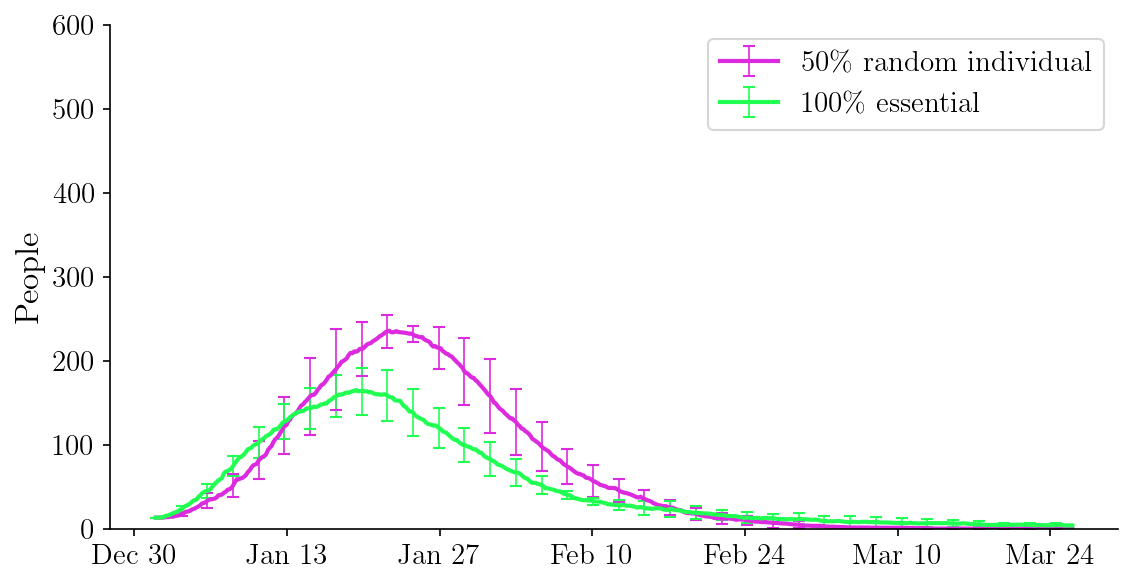

In [37]:
# downsized 100 by pop, 20 by town, 4 random repeats
# 47.19% essential to total prop, essential: 429, non-essential: 480, total: 909, sites:47
# compare supermarket & restuarant workers compliant vs. random complaint, number of compliant ~=
# compare 100% compliance for supermarket & restuarant, 50% for random individual
# mob rate regular: same as German town
# mob rate bus: 5 days per week,5 hours per day, essential_mob_rate_per_type = [0.0 , 0.0 , 5.0 , 5.0, 0.0]
# mob rate office: 5 days per week,5 hours per day,essential_dur_mean_per_type = [0.0 , 0.0 , 5.0 , 5.0, 0.0]
# mob rate zero elsewhere
# run 3

plotter = Plotter()
# titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance_essential])
titles_SD_6_ = ['50\% random individual','100\% essential']
for j, policy in enumerate(['basic']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' tracing isolation'),
        filename=runstr + f'SD_6{j}', 
        figsize=FIGSIZE, acc=500, 
        ymax=600, errorevery=14)

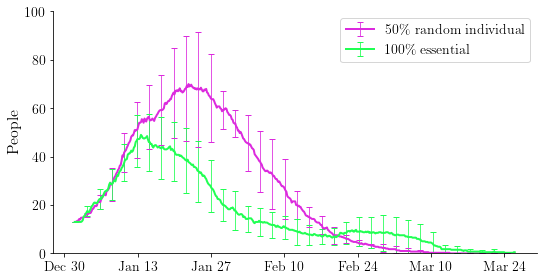

In [10]:
# downsized 100 by pop, 20 by town, 4 random repeats
# 47.19% essential to total prop, essential: 429, non-essential: 480, total: 909, sites:47
# compare supermarket & restuarant workers compliant vs. random complaint, number of compliant ~=
# compare 100% compliance for school & office, 50% for random individual
# mob rate regular: same as German town
# essential mob rate school: 5 days per week,5 hours per day, essential_mob_rate_per_type = [5.0 , 0.0 , 5.0 , 0.0, 0.0]
# essential mob rate office: 5 days per week,5 hours per day,essential_dur_mean_per_type = [5.0 , 0.0 , 5.0 , 0.0, 0.0]
# essential mob rate zero elsewhere
# run 1

plotter = Plotter()
# titles_SD_6_ = list(['Tracking compliance '+ str(int(p*100.0)) + ' \%' for p in p_compliance_essential])
titles_SD_6_ = ['50\% random individual','100\% essential']
for j, policy in enumerate(['basic']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=titles_SD_6_, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' tracing isolation'),
        filename=runstr + f'SD_6{j}', 
        figsize=FIGSIZE, acc=500, 
        ymax=100, errorevery=14)

In [30]:
case = 'super_s.pk'
name = case[0:len(case)-3]
name1 = 'summaries_'+name
print(p_essential)

1.0


In [35]:
save_summary(summaries_SD_6,'comp'+str(p_essential)+'_repeats'+str(random_repeats)+'_'+mob_settings)